In [2]:
pip install --upgrade xgboost

In [1]:
# Step 1: Import Libraries
from sklearn.metrics import mean_squared_error
from numpy import log1p, expm1
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as n

In [3]:
from google.colab import files
uploaded = files.upload()

Saving ts_imputed_xgboost.csv to ts_imputed_xgboost.csv


In [47]:
df = pd.read_csv('ts_imputed_xgboost.csv')

In [5]:
# Select relevant features for the model
features = ['HIV_seropositivity_genpop', 'Linkage_to_ART', 'HIV_seropositivity_PMTCT', 'percent_VLC',
            'percent_Not_on_ART', 'new_on_PrEP', 'GINI_index', 'MMR', 'percent_pop_0.14yrs', 'percent_pop_15.64yrs']
target = 'percent_VLS'


In [48]:
# Prepare the data
X = df[features]
y = df[target]


In [49]:
# Step 2: Log Transform the Features and Target
X_log_transformed = X.apply(log1p)  # Apply log transformation to features
y_log_transformed = log1p(y)  # Apply log transformation to target variable


In [50]:
# Step 3: Split the log-transformed data into training and testing sets
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log_transformed, y_log_transformed, test_size=0.2, random_state=42)


In [51]:
# Step 4: Train the XGBoost Model on log-transformed data
model_log = XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
model_log.fit(X_train_log, y_train_log)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [52]:
# Step 5: Predict on Train and Test Set
y_train_pred_log = model_log.predict(X_train_log)
y_test_pred_log = model_log.predict(X_test_log)


In [53]:
# Inverse the log transformation to get the original scale predictions
y_train_pred = expm1(y_train_pred_log)
y_test_pred = expm1(y_test_pred_log)
y_train_original = expm1(y_train_log)
y_test_original = expm1(y_test_log)


In [54]:
# Step 6: Calculate RMSE for both Training and Testing sets
rmse_train_log_transformed = mean_squared_error(y_train_original, y_train_pred, squared=False)
rmse_test_log_transformed = mean_squared_error(y_test_original, y_test_pred, squared=False)


In [55]:
# Print RMSE for both sets
print(f"RMSE (Training Set): {rmse_train_log_transformed:.4f}")
print(f"RMSE (Testing Set): {rmse_test_log_transformed:.4f}")

RMSE (Training Set): 1.2181
RMSE (Testing Set): 2.3941


In [73]:
# Step 7: Feature Importance Plot using different cool colormaps
importance_log = model_log.feature_importances_
feature_importance_log = pd.Series(importance_log, index=features)

In [85]:
# Available cool color themes: 'cool', 'winter', 'cividis'
color_map_choice = 'cool'  # Change this to 'cool' or 'winter' as desired

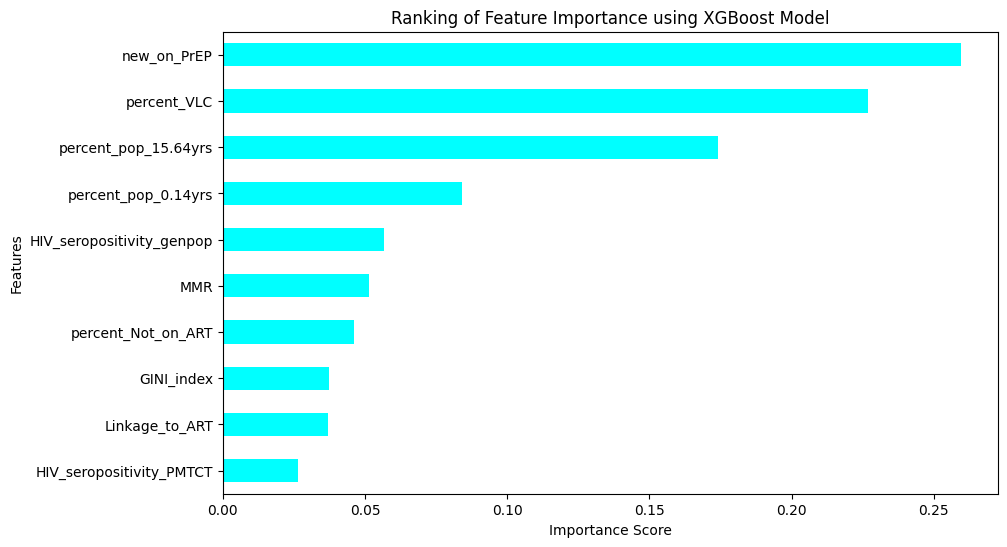

In [88]:
plt.figure(figsize=(10, 6))
feature_importance_log.sort_values().plot(kind='barh', colormap=color_map_choice)  # Use the chosen colormap
plt.title(f'Ranking of Feature Importance using XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [64]:
# Step 8: Prepare Data for Time Series Forecasting using the most recent data
# Generate a future data frame with dates for the next 6 years
future_years = pd.date_range(start='2025-01-01', periods=6, freq='Y')

# Using the last 6 records from the current dataset as an example
future_features = X.tail(6).apply(log1p).values  # Apply log transformation

# Predict viral load suppression for the future years using the log-transformed model
future_pred_log = model_log.predict(future_features)
future_pred = expm1(future_pred_log)  # Inverse log transformation to get original scale

In [65]:
# Step 9: Aggregate Historical Data
# Calculate the mean or median of percent_VLS across all countries for each year
aggregated_historical_data = df.groupby('year')['percent_VLS'].mean().reset_index()


In [66]:
# Step 10: Combine Historical and Forecast Data
forecast_data = pd.DataFrame({'year': future_years.year, 'percent_VLS': future_pred})


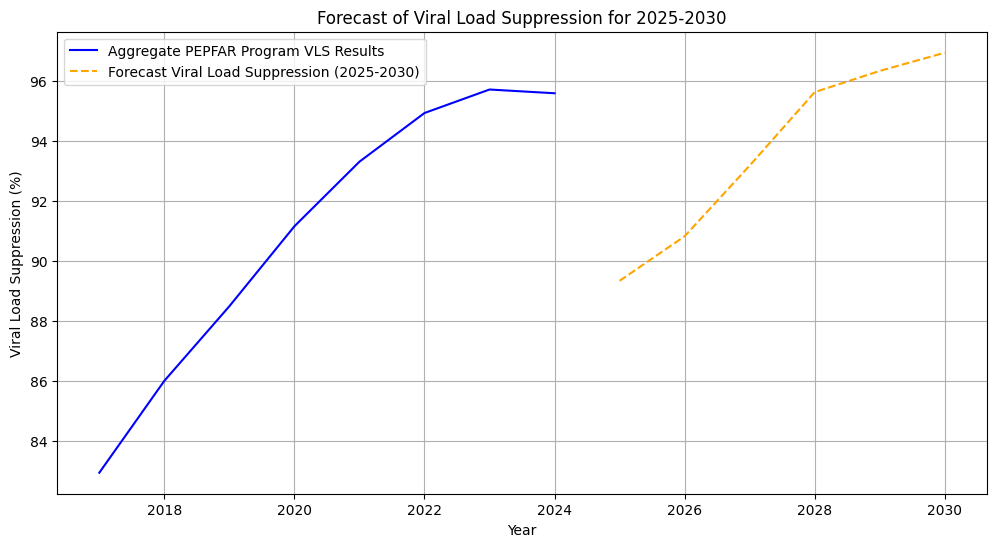

In [69]:
# Step 11: Plot Aggregated Historical and Forecasted Data
plt.figure(figsize=(12, 6))

# Plot aggregated historical data
plt.plot(aggregated_historical_data['year'], aggregated_historical_data['percent_VLS'], label='Aggregate PEPFAR Program VLS Results', linestyle='-', color='blue')

# Plot forecasted data
plt.plot(forecast_data['year'], forecast_data['percent_VLS'], label='Forecast Viral Load Suppression (2025-2030)', linestyle='--', color='orange')

# Add title, labels, and legend
plt.title('Forecast of Viral Load Suppression for 2025-2030')
plt.xlabel('Year')
plt.ylabel('Viral Load Suppression (%)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Hypaparameter Tuning

In [92]:
# Step 1: Import Libraries
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [89]:
# Select relevant features for the model
features = ['HIV_seropositivity_genpop', 'Linkage_to_ART', 'HIV_seropositivity_PMTCT', 'percent_VLC',
            'percent_Not_on_ART', 'new_on_PrEP', 'GINI_index', 'MMR', 'percent_pop_0.14yrs', 'percent_pop_15.64yrs']
target = 'percent_VLS'

In [90]:
# Prepare the data
X = df[features]
y = df[target]

In [93]:
# Step 2: Log Transform the Features and Target
X_log_transformed = X.apply(np.log1p)  # Apply log transformation to features
y_log_transformed = np.log1p(y)  # Apply log transformation to target variable


In [94]:
# Step 3: Split the log-transformed data into training and testing sets
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log_transformed, y_log_transformed, test_size=0.2, random_state=42)


In [95]:
# Step 4: Define Hyperparameter Grid for Randomized Search
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3]
}

In [96]:
# Step 5: Set up RandomizedSearchCV with 5-Fold Cross Validation
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [97]:
# Step 6: Fit RandomizedSearchCV
random_search.fit(X_train_log, y_train_log)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.15],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': [50, 100, 200, 300],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [98]:
# Step 7: Extract the Best Parameters and Retrain the Model
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")

best_xgb_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_xgb_model.fit(X_train_log, y_train_log)


Best Hyperparameters: {'subsample': 0.7, 'n_estimators': 300, 'min_child_weight': 4, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [100]:
# Step 8: Predict on Train and Test Set
y_train_pred_log = best_xgb_model.predict(X_train_log)
y_test_pred_log = best_xgb_model.predict(X_test_log)

# Inverse the log transformation to get the original scale predictions
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)
y_train_original = np.expm1(y_train_log)
y_test_original = np.expm1(y_test_log)


In [101]:
# Step 9: Calculate RMSE for both Training and Testing sets
rmse_train_log_transformed = mean_squared_error(y_train_original, y_train_pred, squared=False)
rmse_test_log_transformed = mean_squared_error(y_test_original, y_test_pred, squared=False)

# Print RMSE for both sets
print(f"RMSE (Training Set): {rmse_train_log_transformed:.4f}")
print(f"RMSE (Testing Set): {rmse_test_log_transformed:.4f}")


RMSE (Training Set): 1.6151
RMSE (Testing Set): 2.3036


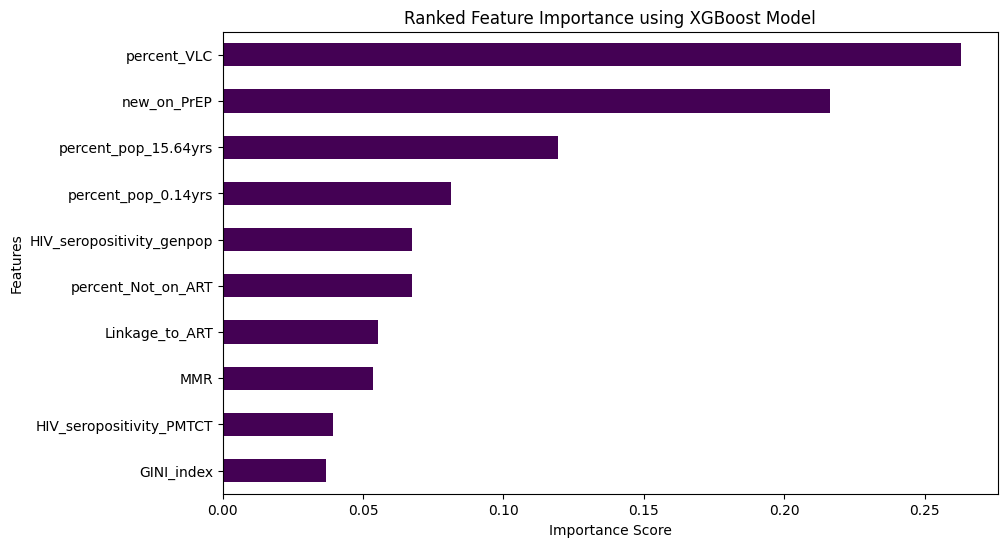

In [111]:
# Step 10: Feature Importance Plot using different cool colormaps
importance_log = best_xgb_model.feature_importances_
feature_importance_log = pd.Series(importance_log, index=features)

# Available cool color themes: 'cool', 'winter', 'cividis'
color_map_choice = 'viridis'  # Change this to 'cool' or 'winter' as desired

plt.figure(figsize=(10, 6))
feature_importance_log.sort_values().plot(kind='barh', colormap=color_map_choice)  # Use the chosen colormap
plt.title(f'Ranked Feature Importance using XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


In [105]:
# Step 11: Prepare Data for Time Series Forecasting using the most recent data
# Generate a future data frame with dates for the next 6 years
future_years = pd.date_range(start='2025-01-01', periods=6, freq='Y')

# Using the last 6 records from the current dataset as an example
future_features = X.tail(6).apply(np.log1p).values  # Apply log transformation

# Predict viral load suppression for the future years using the tuned XGBoost model
future_pred_log = best_xgb_model.predict(future_features)
future_pred = np.expm1(future_pred_log)  # Inverse log transformation to get original scale


In [106]:
# Step 12: Aggregate Historical Data
# Calculate the mean or median of percent_VLS across all countries for each year
aggregated_historical_data = df.groupby('year')['percent_VLS'].mean().reset_index()


In [107]:
# Step 13: Combine Historical and Forecast Data
forecast_data = pd.DataFrame({'year': future_years.year, 'percent_VLS': future_pred})


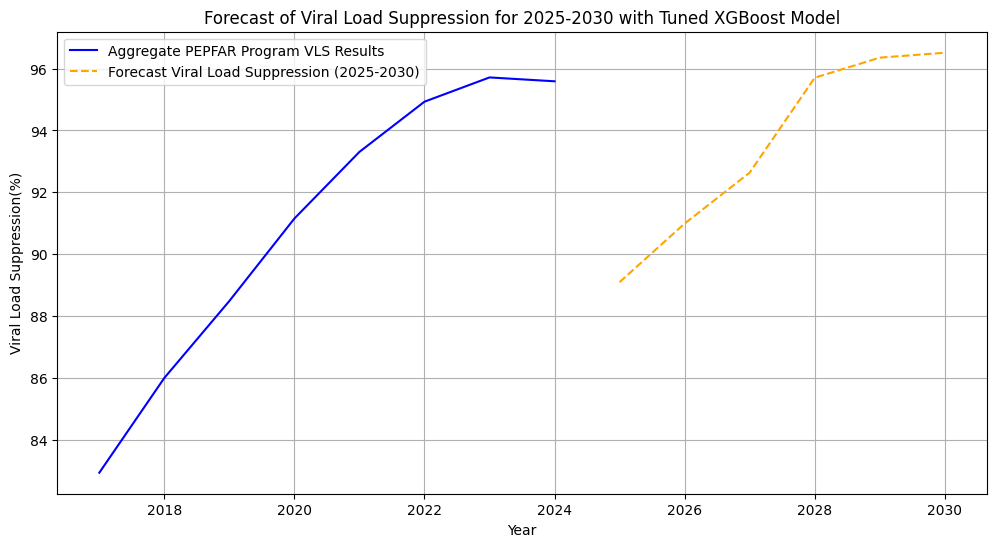

In [110]:
# Step 14: Plot Aggregated Historical and Forecasted Data
plt.figure(figsize=(12, 6))

# Plot aggregated historical data
plt.plot(aggregated_historical_data['year'], aggregated_historical_data['percent_VLS'], label='Aggregate PEPFAR Program VLS Results', linestyle='-', color='blue')

# Plot forecasted data
plt.plot(forecast_data['year'], forecast_data['percent_VLS'], label='Forecast Viral Load Suppression (2025-2030)', linestyle='--', color='orange')

# Add title, labels, and legend
plt.title('Forecast of Viral Load Suppression for 2025-2030 with Tuned XGBoost Model')
plt.xlabel('Year')
plt.ylabel('Viral Load Suppression(%)')
plt.legend(loc='best')
plt.grid(True)
plt.show()